# Cough detection
## Authors
- [quirinoc](https://github.com/quirinoc)
- [Guillermo](https://github.com/memoherreraacosta)
- Cabello
- Karol
- Daniela

## Based on 
### [Music Genre Classification using Hidden Markov Models - Salih Boutadghart](https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4)

# Prepare modules

In [69]:
! pip install -r requirements.txt --quiet

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as path

from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from random import randint, shuffle

import itertools
import os
import glob

## HMM Methods

In [121]:
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type,n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type') 

    def train(self, X):
        np.seterr(all='ignore')
        self.model.fit(X)
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [122]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm,
               interpolation='nearest',
               cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(
        tick_marks,
        classes,
        rotation=45)
    
    plt.yticks(
        tick_marks,
        classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [123]:
def test_category(models, data, label):
    pred_labels = []
    for mfcc_filter in data:
        category = get_pred(models, mfcc_filter)
        pred_labels.append(
            category == label
        )
    return pred_labels

In [124]:
def get_pred(models, data):
    max_score = float('-inf')
    max_score_category = None
    for category in models:
        score = models[category].get_score(data)
        if score > max_score:
            max_score = score
            max_score_category = category
    return max_score_category

## EDA

In [125]:
categories = ['cough', 'no_cough']

In [126]:
sampling_freq, audio = wavfile.read("data/cough/15435__acclivity__goatsinthedust.wav")
mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [127]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 7216
Length of each feature = 13

Filter bank:
Number of windows = 7216
Length of each feature = 26


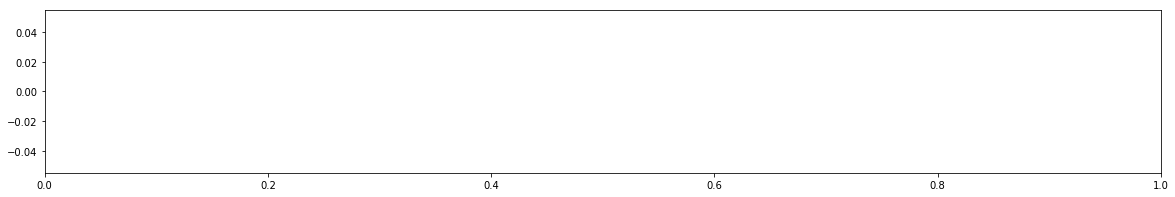

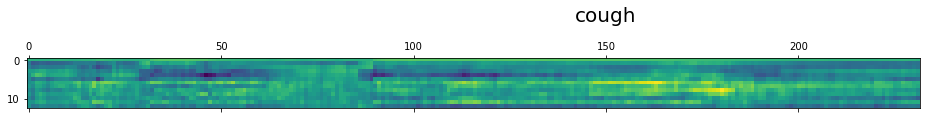

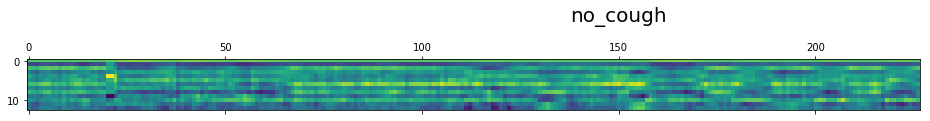

In [128]:
figure = plt.figure(figsize=(20,3))
for category in categories: 
    example_data_path = path.join('data', category)
    file_paths = glob.glob(path.join(example_data_path, '*.wav'))
    sampling_freq, audio = wavfile.read(file_paths[randint(0, len(file_paths) - 1)])
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    plt.yscale('linear')
    plt.matshow((mfcc_features.T)[:,:300])
    plt.text(150, -10, category, horizontalalignment='center', fontsize=20)

plt.yscale('linear')
plt.show()

In [129]:
input_folder = 'data'

mfcc_data_split = {category : [] for category in categories}
hmm_models = {}
mfcc_data = {}

# Parse the input directory
for category in categories:
    # Get the name of the subfolder
    subfolder = os.path.join(input_folder, category)
    if not os.path.isdir(subfolder):
        print(f'Invalid dir: {subfolder} does not exists!'); break
    # Iterate through the audio files (leaving 1 file for testing in each class)
    for filepath in glob.glob(path.join(subfolder, '*.wav')):
        try:
            sampling_freq, audio = wavfile.read(filepath)
        except:
            continue
        # Extract MFCC features
        mfcc_features = mfcc(audio, sampling_freq)
        mfcc_data_split[category].append(mfcc_features)

In [135]:
# Split into Training / Testing
train_data = {}
test_data = {}
train_data_split = {}
test_data_split = {}

split_per = 0.50757575
for category in mfcc_data_split:
    data = mfcc_data_split[category]
    shuffle(data)
    n = int(len(data) * split_per)
    train, test = data[:n], data[n:]
    train_data_split[category] = train
    test_data_split[category] = test
    train_data[category] = np.concatenate(train_data_split[category], axis=0)
    test_data[category] = np.concatenate(test_data_split[category], axis=0)

In [136]:
# Create models
for category in categories:
    hmm_trainer = HMMTrainer(n_components=10)
    hmm_models[category] = hmm_trainer

In [137]:
for category in categories:
    shuffle(train_data[category])
    hmm_models[category].train(train_data[category][:10000])

## Testing

In [138]:
input_folder = 'data/'
# categories = ['cough','no_cough']
real_labels = []
pred_labels = []
for category in categories:
    for mfcc_features in test_data_split[category]:
        pred = get_pred(hmm_models, mfcc_features)
        real_labels.append(category)
        pred_labels.append(pred)
        
cough_c = 0
no_cough_c = 0
total = 0

for pred, real in zip(pred_labels, real_labels):
    if pred == real:
        if real == 'cough':
            cough_c += 1
        elif real == 'no_cough':
            no_cough_c +=1
    total += 1
    
print(cough_c / len(test_data_split['cough']))
print(no_cough_c / len(test_data_split['no_cough']))
print(total / len(pred))

0.8383838383838383
0.2159090909090909
37.4


[[83 16]
 [69 19]]
Normalized confusion matrix


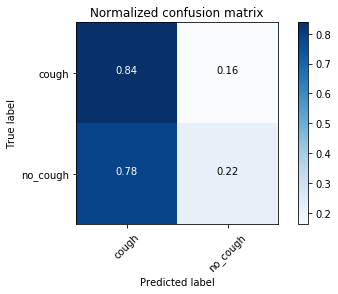

In [139]:
cm = confusion_matrix(real_labels, pred_labels)
print(cm)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm,
                      classes=categories,
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()